<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Yogi_LogaU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# **Does a Dependency Between Movie Distributors Exist When Looking at Films' Gross Revenues?**







The film industry is a complex ecosystem where various distributors fight over viewership. In my project, I intend to explore whether a dependency exists between the gross revenue of a film and its distributor so I can gain more insight into this dynamic world.

Before conducting the project, I'm going to assume that their is an inherent dependency between how a film performs and the distributor responsible for producing it. My hypothesis is backed by my own inclination to hold movies from producers like Disney and Paramount at a higher standard (I basically tend to view them more).
***

## **The Data**
The data below was extracted from the official Box Office site and has all the Domestic movies from 2010.

In [3]:
movie_data= pd.read_csv('https://raw.githubusercontent.com/YogithL/Data-Science/refs/heads/main/Data%20for%20Data%20Science%20Unit4%20%20-%20Sheet1.csv', dtype={'Distributor':'category'})
movie_data

,Rank,Release,Gross,Theaters,Opening,% of Total,Distributor
0,1,Toy Story 3,415004880,4028,110307189.0,26.60%,Walt Disney Studios Motion Pictures
1,2,Alice in Wonderland,334191110,3739,116101023.0,34.70%,Walt Disney Studios Motion Pictures
2,3,Iron Man 2,312433331,4390,128122480.0,41%,Paramount Pictures
3,4,The Twilight Saga: Eclipse,300531751,4468,64832191.0,21.60%,Summit Entertainment
4,5,Harry Potter and the Deathly Hallows: Part 1,295983305,4125,125017372.0,42.20%,Warner Bros.
...,...,...,...,...,...,...,...
195,196,The Oscar Nominated Short Films 2010: Live Action,1018169,95,NaN,28.60%,Shorts International
196,197,Guzaarish,1017335,108,67848.0,48%,UTV Motion Pictures
197,198,The Salvation Poem,914818,30,186995.0,Solo Film,CanZion Films
198,199,The Wildest Dream,898137,21,67848.0,7.60%,National Geographic Entertainment


Since we're only concerned about 2 variables, let's remove the rest for clarity. While we're at it, lets also calculate our gross revenue in millions to make the computer's job easier.

In [4]:

movie_data=movie_data.loc[:, ['Gross', 'Distributor']] #Removing all columns excluding Gross and Distributor

movie_data['Gross'] = (movie_data['Gross'] / 1e6).round(3) #Dividing by a million and rounding to 3 decimal places

movie_data

,Gross,Distributor
0,415.005,Walt Disney Studios Motion Pictures
1,334.191,Walt Disney Studios Motion Pictures
2,312.433,Paramount Pictures
3,300.532,Summit Entertainment
4,295.983,Warner Bros.
...,...,...
195,1.018,Shorts International
196,1.017,UTV Motion Pictures
197,0.915,CanZion Films
198,0.898,National Geographic Entertainment


Before moving on, let's transform our data so our computer can actually process our different categories.

In [5]:
#Identifies all the different Distributors and stores that information in the variable
dist_encode = pd.Categorical(movie_data['Distributor'])

#Replaces all the distributor's names with a number in the variable
dist_idx = dist_encode.codes

#Stores the category names in a dictionary so the model can associate different numbers with their corresponding categories
dist_coords = {"Distributor": dist_encode.categories}

dist_coords

{'Distributor': Index(['3D Entertainment', 'ATO Pictures', 'Anchor Bay Films', 'Apparition',
        'CBS Films', 'CanZion Films', 'DreamWorks', 'Eros Worldwide',
        'Focus Features', 'Freestyle Releasing', 'IFC Films', 'Lionsgate',
        'Magnolia Pictures', 'MetroSolo FilmGoldwynSolo FilmMayer (MGM)',
        'Miramax', 'Music Box Films', 'National Geographic Entertainment',
        'Overture Films', 'Paramount Pictures', 'Paramount Vantage',
        'Relativity Media', 'Reliance Big Pictures', 'Roadside Attractions',
        'Rogue Pictures', 'Screen Gems', 'Screen Media Films',
        'Shorts International', 'Solo Film', 'Sony Pictures Classics',
        'Sony Pictures Releasing', 'Summit Entertainment',
        'The Samuel Goldwyn Company', 'The Weinstein Company',
        'Twentieth Century Fox', 'UTV Motion Pictures', 'Universal Pictures',
        'Vivendi Entertainment', 'Walt Disney Studios Motion Pictures',
        'Warner Bros.'],
       dtype='object')}

## **Visualizations**


Now that we have our data all cleaned up, let's visualize it. I perfer a combination of the kdeplot and rugplot so I can get a quick summary of the shape and frequency of our data. But I'll still take a look at a couple more graphs.

<Axes: xlabel='Gross', ylabel='Density'>

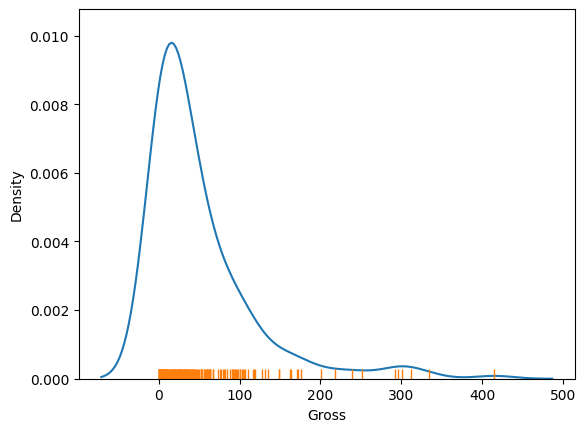

In [6]:
sns.kdeplot(data=movie_data, x="Gross")
sns.rugplot(data=movie_data, x="Gross")

<Axes: xlabel='Gross'>

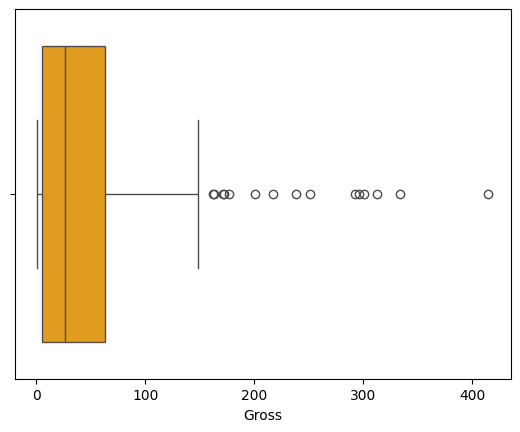

In [21]:
sns.boxplot(data=movie_data, x="Gross", color="orange")

<Axes: xlabel='Gross'>

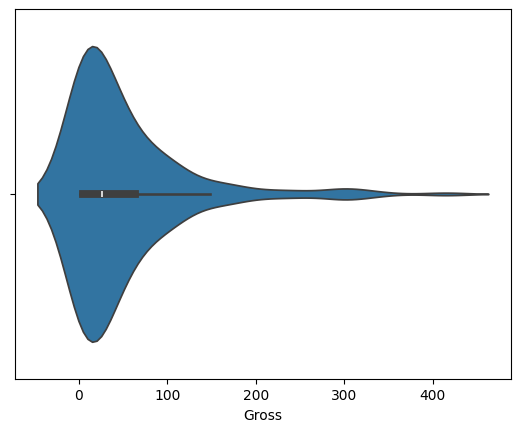

In [24]:
sns.violinplot(data=movie_data, x="Gross")

From the graphs, it's clear to see that the distribution is positively skewed and non-negative. The non-negative aspect is because we're measuring revenue, not profit, so the lowest we could possibly get is 0. Additionally, since we're measuring money, we can assume the data is continuous. Notably, a LARGE amount of data is between 0-100 million dollars.

## **Choosing Likelihoods and Priors**


Given the constraints above, I instantly knew what likelihood I wanted to use. Since my Unit 3 project explored a similar set of data and produced the same constraints for a model, I decided that using a **Gamma distribution** would work great. Specifically, the distribution was built to handle cases like these were a large proportion of the data is concentrated at a range and there are a few extreme outliers.

<Axes: >

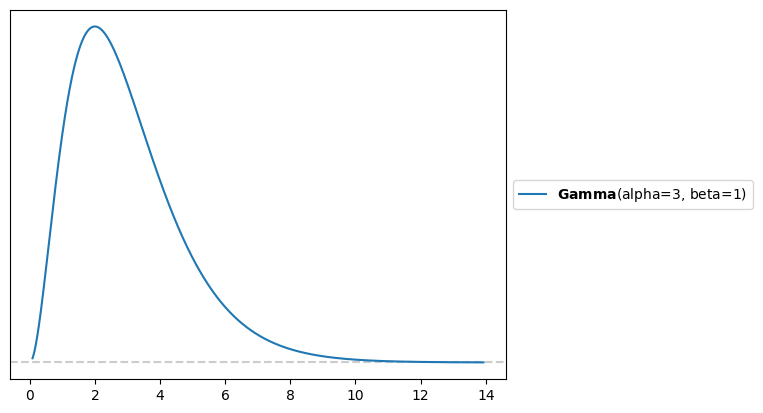

In [30]:
pz.Gamma(alpha=3, beta=1).plot_pdf()

Since we're using a Gamma distribution, our two parameters are *alpha* and *beta*. On a quick side note, I tried using *mu* and *sigma* for my parameters since they're technically allowed, but my model ended up having 30+ divergences. I learned that it was because *mu* and *sigma* often assume normality, and in this case, we don't want that.

The alpha parameter controls the shape of the distribution so I decided to use a **Gamma distribution** here. This is because we'll have a flexible model  that's positively skewed. For the Gamma distribution, I decided to use a value of 2 for alpha, because our data has a relatively strong skew. And for beta, I decided to use a value of 1 since our graph has a narrow peak.

The beta parameter controls the spread of our distribution so I decided to use a **HalfNormal distribution**. This ensures our spread will be constrained to non-negative values and  fit the nature of our data. It also lets us accomodate for larger values when we need. I chose a sigma of .4 for our HalfNormal distribution by referencing the API with our visualizations in mind.    

<Axes: >

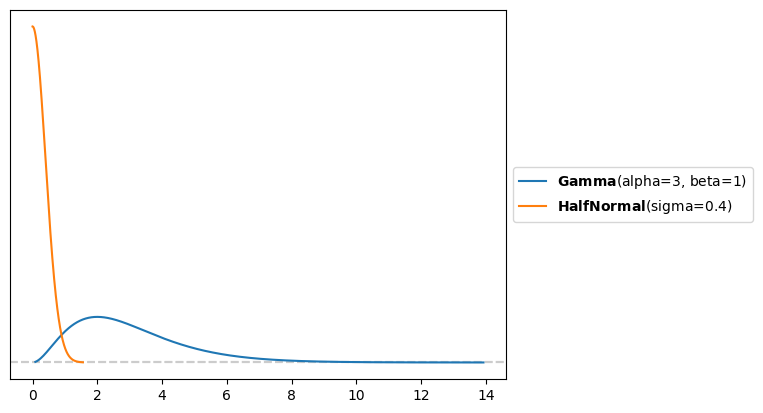

In [33]:
pz.Gamma(alpha=3, beta=1).plot_pdf()
pz.HalfNormal(sigma=.4).plot_pdf()

## **Constructing our Non Hierarchical Model**

In [31]:
with pm.Model(coords=dist_coords) as dist_NH_model:
    #priors
    #dims to apply the prior seperately to each distributor
    a = pm.Gamma('a',alpha=2, beta=1, dims="Distributor")
    b = pm.HalfNormal('b', sigma=.4, dims="Distributor")

    #The idx variable tells the model which revenues belong to which distributor
    y = pm.Gamma('NH', alpha = a[dist_idx], beta = b[dist_idx], observed=movie_data.Gross)

    data_d_NH = pm.sample(target_accept = 0.95)


Output()

Output()

Output()

(0.0, 400.0)

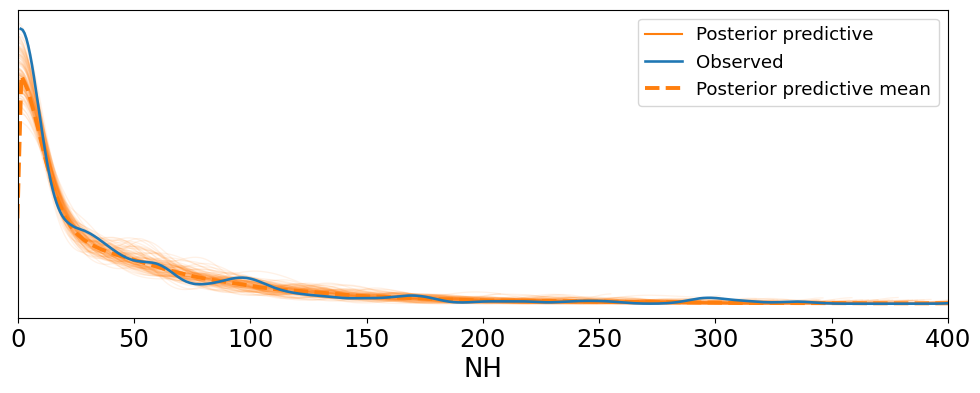

In [32]:
    pm.sample_posterior_predictive(data_d_NH, model=dist_NH_model, extend_inferencedata=True)

    az.plot_ppc(data_d_NH, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"], alpha =.1) #alpha = .1 makes Posterior Predictive traces less opaque

    plt.xlim(0, 400) #Zooming in

The model above works pretty well. Disregarding the small bumps (I think its just noise), the only issue is that the peak is a bit high. I tried changing the parameters to compensate for this, but it ended being inefficient: either their were too many divergences, no change at all, or the model became worse.   

## **Constructing our Hierarchical Model**

Before I run my model, let me explain why I chose these hyperpriors:
1.   **alpha_hyper-** Since the alpha parameter dictates the shape, having a **LogNormal Distribution** will allow alpha to vary in a positive range, skewing to smaller values. This is important because lower values of alpha help the graph skew to the right.

2.   **beta_hyper-** Since we're using a **HalfNormal Distribution**, the values of Beta will be constrained around a central positive value, giving us a little flexibilty while we also avoid the negative values.  

3.   **sigma_hyper-** I used a **HalfCauchy Distribution** for this hyper simply because I wanted to capture a wide range of Betas (since I wasn't exactly sure what I needed).



In [9]:
with pm.Model(coords=dist_coords) as dist_H_model:
    #Hyperpriors
    alpha_hyper= pm.LogNormal('alpha_hyper', mu=1, sigma=.5)
    beta_hyper= pm.HalfNormal('beta_hyper', sigma=2)
    sigma_hyper= pm.HalfCauchy('sigma hyper', beta=5)

    #Priors
    alpha = pm.Gamma('alpha', alpha=alpha_hyper, beta=beta_hyper, dims="Distributor")
    beta = pm.HalfNormal('beta', sigma=sigma_hyper, dims="Distributor")

    #Likelihood
    y = pm.Gamma('H', alpha = alpha[dist_idx], beta = beta[dist_idx], observed=movie_data.Gross)

    data_d_H = pm.sample(target_accept = 0.95)


Output()

Output()

Output()

(0.0, 400.0)

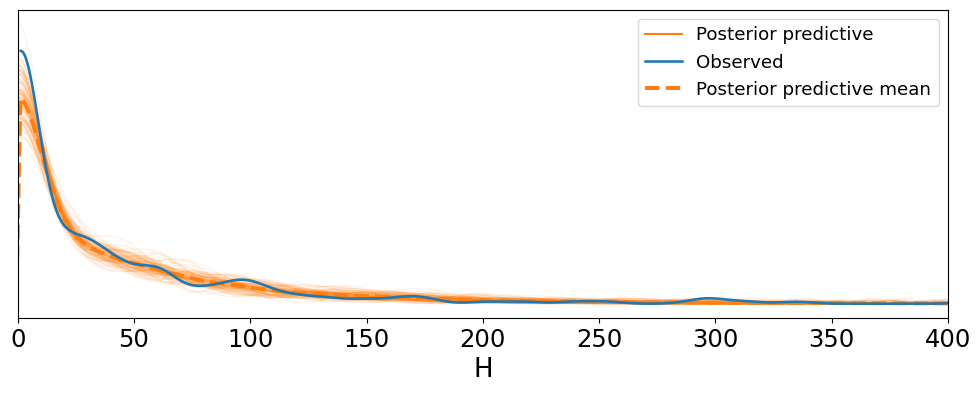

In [10]:
    pm.sample_posterior_predictive(data_d_H, model=dist_H_model, extend_inferencedata=True)

    az.plot_ppc(data_d_H, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"], alpha =.1) #Read online that this makes the posterior predictive more

    plt.xlim(0, 400)

Our model looks really similar to the NH model; to double check I didn't mess anything up, I ran a markov chain and ran R-hat.

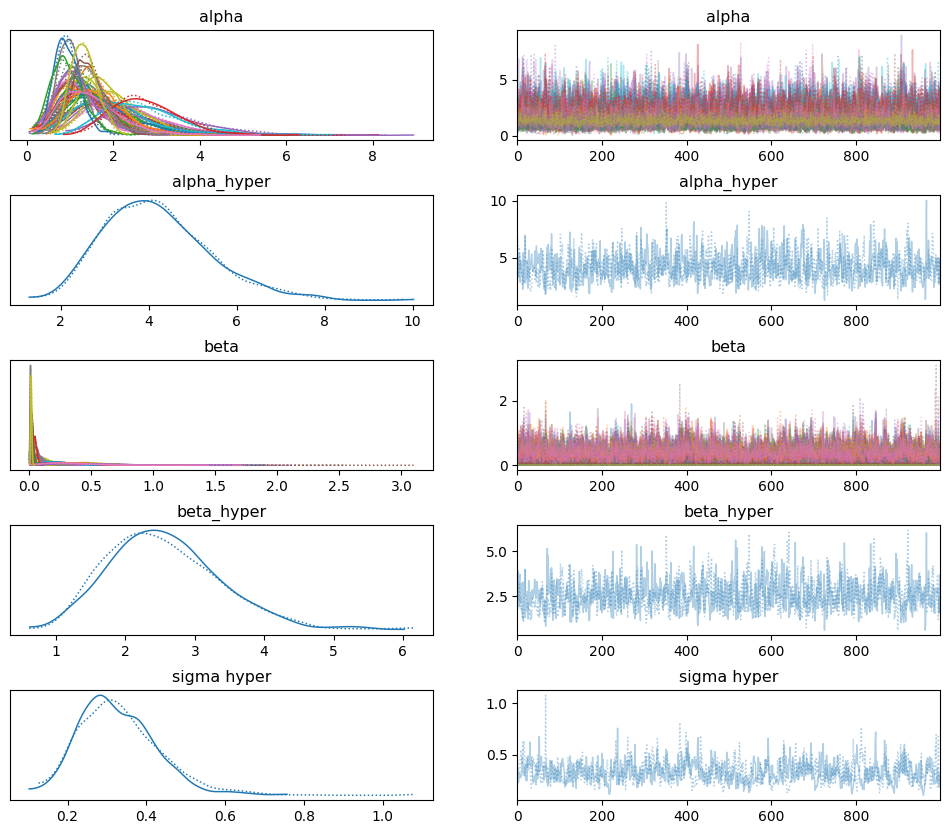

In [11]:
az.plot_trace(data_d_H)
plt.subplots_adjust(hspace=0.5)

In [12]:
az.rhat(data_d_H)

<xarray.Dataset> Size: 7kB
Dimensions:      (Distributor: 39)
Coordinates:
  * Distributor  (Distributor) <U41 6kB '3D Entertainment' ... 'Warner Bros.'
Data variables:
    alpha        (Distributor) float64 312B 0.9996 1.001 1.001 ... 1.001 1.0
    alpha_hyper  float64 8B 1.0
    beta         (Distributor) float64 312B 1.002 1.002 0.9996 ... 1.002 0.9999
    beta_hyper   float64 8B 1.002
    sigma hyper  float64 8B 1.007

So that was weird. Our Markov Chain's amplitudes were fairly consistent and none of our R-hat values were too extreme. I tried a couple more times, tinkering with different parameter values but nothing worked. I even tryed making the mu parameter of my alpha_hyper negative in hopes my curve would shift down, but still, nothing worked. The graph still looked similar to the Non-Hierarchical model, the Markov Chain's were fine, and the R-hats were not too far from the necessary range.   

In [17]:
with pm.Model(coords=dist_coords) as dist_H2_model:
    #Hyperpriors
    alpha_hyper= pm.LogNormal('alpha_hyper', mu=-2, sigma=2)
    beta_hyper= pm.Gamma('beta_hyper', alpha=2, beta=0.5)
    sigma_hyper= pm.LogNormal('sigma_hyper', mu=0, sigma=1)

    #Priors
    alpha = pm.Gamma('alpha', alpha=alpha_hyper, beta=beta_hyper, dims="Distributor")
    beta = pm.HalfNormal('beta', sigma=sigma_hyper, dims="Distributor")

    #Likelihood
    y = pm.Gamma('H', alpha = alpha[dist_idx], beta = beta[dist_idx], observed=movie_data.Gross)

    data_d_H = pm.sample(target_accept = 0.95)


Output()

Output()

Output()

(0.0, 400.0)

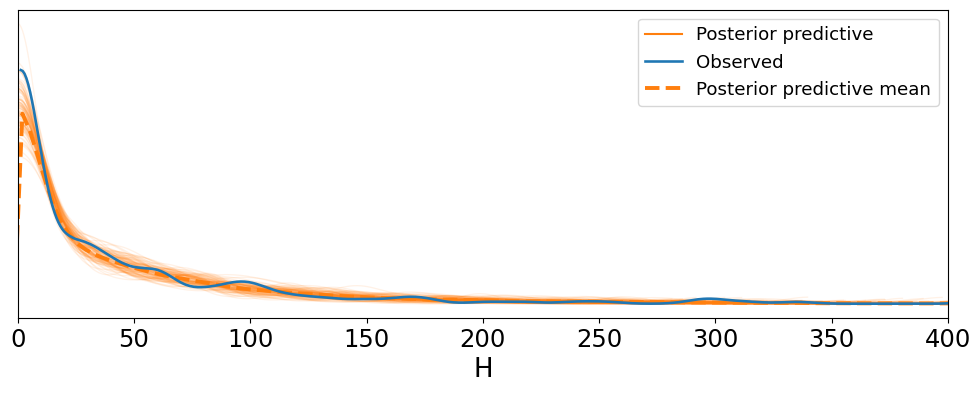

In [18]:
    pm.sample_posterior_predictive(data_d_H, model=dist_H2_model, extend_inferencedata=True)

    az.plot_ppc(data_d_H, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"], alpha =.1) #Read online that this makes the posterior predictive more

    plt.xlim(0, 400)

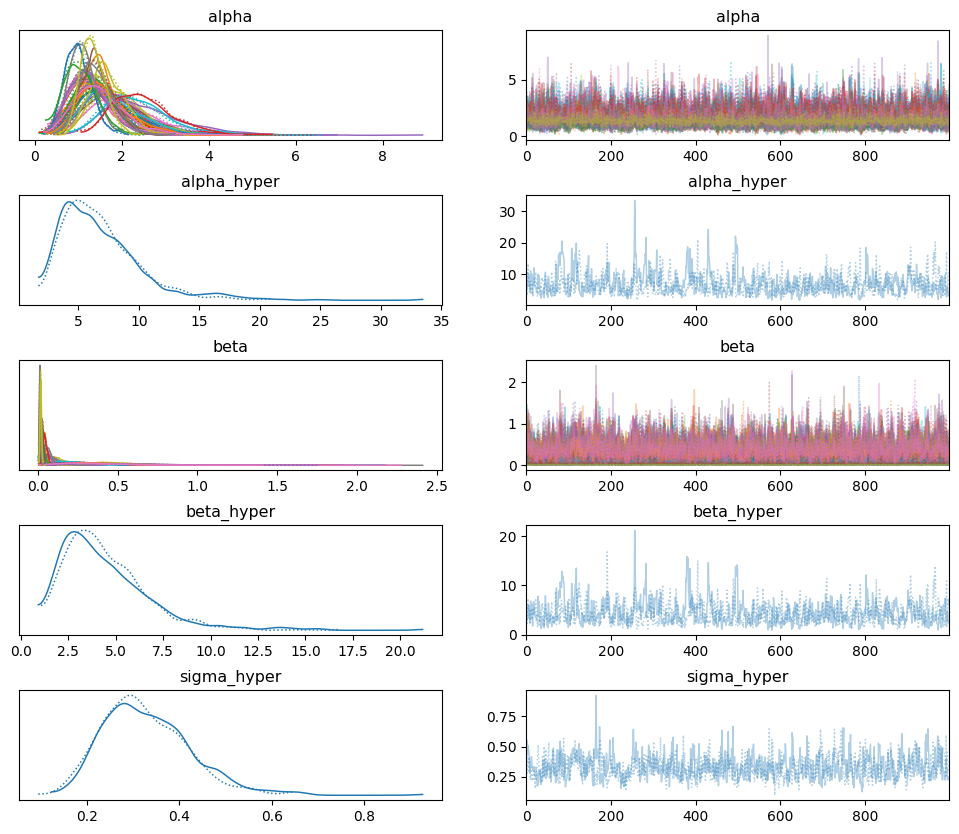

In [19]:
az.plot_trace(data_d_H)
plt.subplots_adjust(hspace=0.5)

In [20]:
az.rhat(data_d_H)

<xarray.Dataset> Size: 7kB
Dimensions:      (Distributor: 39)
Coordinates:
  * Distributor  (Distributor) <U41 6kB '3D Entertainment' ... 'Warner Bros.'
Data variables:
    alpha        (Distributor) float64 312B 0.9998 1.0 0.9995 ... 1.003 1.0
    alpha_hyper  float64 8B 1.013
    beta         (Distributor) float64 312B 1.002 1.001 1.0 ... 0.9999 1.004 1.0
    beta_hyper   float64 8B 1.012
    sigma_hyper  float64 8B 1.002

## **Final Thoughts**

So the outcome was nowhere near what I predicted. I'll be honest, I was pretty confident that my hypothesis was right and that maybe this wasn't even a question worth asking. I could've tried arguing that the Hierarchical model was better because it was just so every slightly closer to the Posterior Predictive Mean (PPM), but that would've been a stretch. So, instead, I want to use this cell to argue why the results of the data actually make sense. This is assuming I didn't mess up anywhere in the actual code. That said, I'm confident my methodology was correct: I used the proper Likelihoods, Priors, and Hyperpriors. Even my Markov Chains and R-hat values were fine.

To my knowledge, if the Non-Hierarchical and Hierarchical models of the same Likelihood have a similar PPM, there is virtually no variation between the variable measured across the different subgroups. In this case, that means the film revenue patterns of each distributor are alike. So why does this make sense? When parsing through the data myself, I noticed that big players like Disney, Warner Bros, and Paramount took the top spots. But right after you leave the top 10 grossing films---the outliers in our data---distributor's have little impact on the earnings of movies. For instance, distributors I've never heard of like Screen Gems and Overture Films start out earning the *Big 3*. I'm trying to say that outside the podium, sometimes popular, but largely less profitable distributors make movies that gross so much more.

Now my conclusion is starting to make much more sense. The nature of movies is just that. Whether your a giant in the industry, you'll produce a few flops, and whether your a "nobody" you'll still get a few notable hits. This also makes sense regarding the shape of my distribution. It's positively skewed to account for the few films that gross around half a billion, but it's density is still predominantly centered around the lower half.
